In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import lightgbm as lgb
import os, sys
from bayes_opt import BayesianOptimization

In [122]:
train = pd.read_csv('bigquery-geotab-intersection-congestion/train.csv')
test = pd.read_csv('bigquery-geotab-intersection-congestion/test.csv')

In [77]:
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,SE,SE,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,NW,NW,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Atlanta


In [78]:
test.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,City
0,0,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,0,0,6,Peachtree Street Southwest_NE_Peachtree Street...,Atlanta
1,1,1,33.75094,-84.393032,Peachtree Street Southwest,Mitchell Street Southwest,SW,SE,0,0,6,Peachtree Street Southwest_SW_Mitchell Street ...,Atlanta
2,2,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,0,0,6,Peachtree Street Southwest_SW_Peachtree Street...,Atlanta
3,3,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,NE,NE,1,0,6,Peachtree Street Southwest_NE_Peachtree Street...,Atlanta
4,4,1,33.75094,-84.393032,Peachtree Street Southwest,Peachtree Street Southwest,SW,SW,1,0,6,Peachtree Street Southwest_SW_Peachtree Street...,Atlanta


In [79]:
train.nunique()

RowId                      856387
IntersectionId               2559
Latitude                     4799
Longitude                    4804
EntryStreetName              1723
ExitStreetName               1703
EntryHeading                    8
ExitHeading                     8
Hour                           24
Weekend                         2
Month                           9
Path                        15075
TotalTimeStopped_p20          171
TotalTimeStopped_p40          238
TotalTimeStopped_p50          262
TotalTimeStopped_p60          306
TotalTimeStopped_p80          403
TimeFromFirstStop_p20         244
TimeFromFirstStop_p40         316
TimeFromFirstStop_p50         336
TimeFromFirstStop_p60         353
TimeFromFirstStop_p80         355
DistanceToFirstStop_p20      3631
DistanceToFirstStop_p40      6415
DistanceToFirstStop_p50      7751
DistanceToFirstStop_p60      9826
DistanceToFirstStop_p80     13689
City                            4
dtype: int64

In [80]:
train.isna().sum(axis=0)

RowId                         0
IntersectionId                0
Latitude                      0
Longitude                     0
EntryStreetName            8148
ExitStreetName             6287
EntryHeading                  0
ExitHeading                   0
Hour                          0
Weekend                       0
Month                         0
Path                          0
TotalTimeStopped_p20          0
TotalTimeStopped_p40          0
TotalTimeStopped_p50          0
TotalTimeStopped_p60          0
TotalTimeStopped_p80          0
TimeFromFirstStop_p20         0
TimeFromFirstStop_p40         0
TimeFromFirstStop_p50         0
TimeFromFirstStop_p60         0
TimeFromFirstStop_p80         0
DistanceToFirstStop_p20       0
DistanceToFirstStop_p40       0
DistanceToFirstStop_p50       0
DistanceToFirstStop_p60       0
DistanceToFirstStop_p80       0
City                          0
dtype: int64

In [81]:
test.isna().sum(axis=0)

RowId                  0
IntersectionId         0
Latitude               0
Longitude              0
EntryStreetName    19198
ExitStreetName     15587
EntryHeading           0
ExitHeading            0
Hour                   0
Weekend                0
Month                  0
Path                   0
City                   0
dtype: int64

In [82]:
train.shape,test.shape

((856387, 28), (1921357, 13))

In [83]:
road_encoding = {
"Street":0,
 "St":0,
 "Avenue":1,
 "Ave":1,
 "Boulevard":2,
 "Road":3,
 "Drive":4,
 "Lane":5,
 "Tunnel":6,
 "Highway":7,
 "Way":8,
 "Parkway":9,
 "Parking":10,
 "Oval":11,
 "Square":12,
 "Place":13,
 "Bridge":14}

In [84]:
def encode(x):
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
        
    return 0

In [85]:
train['EntryType'] = train['EntryStreetName'].apply(encode)
train['ExitType'] = train['ExitStreetName'].apply(encode)
test['EntryType'] = test['EntryStreetName'].apply(encode)
test['ExitType'] = test['ExitStreetName'].apply(encode)

In [86]:
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

In [87]:
train['EntryHeading'] = train['EntryHeading'].map(directions)
train['ExitHeading'] = train['ExitHeading'].map(directions)

test['EntryHeading'] = test['EntryHeading'].map(directions)
test['ExitHeading'] = test['ExitHeading'].map(directions)

In [88]:
train = pd.concat([train,pd.get_dummies(train["City"],dummy_na=False, drop_first=False)],axis=1).drop(["City"],axis=1)
test = pd.concat([test,pd.get_dummies(test["City"],dummy_na=False, drop_first=False)],axis=1).drop(["City"],axis=1)

In [89]:
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,EntryType,ExitType,Atlanta,Boston,Chicago,Philadelphia
0,1921357,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,1.75,1.75,0,0,...,0.0,0.0,0.0,0.0,2,2,1,0,0,0
1,1921358,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,0.75,0.75,0,0,...,0.0,0.0,0.0,0.0,2,2,1,0,0,0
2,1921359,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,1.75,1.75,1,0,...,0.0,0.0,0.0,0.0,2,2,1,0,0,0
3,1921360,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,0.75,0.75,1,0,...,0.0,0.0,0.0,0.0,2,2,1,0,0,0
4,1921361,0,33.791659,-84.430032,Marietta Boulevard Northwest,Marietta Boulevard Northwest,1.75,1.75,2,0,...,0.0,0.0,0.0,0.0,2,2,1,0,0,0


In [90]:
preds = train.iloc[:,12:27]
train.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'],axis=1, inplace=True)
test.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'],axis=1, inplace=True)

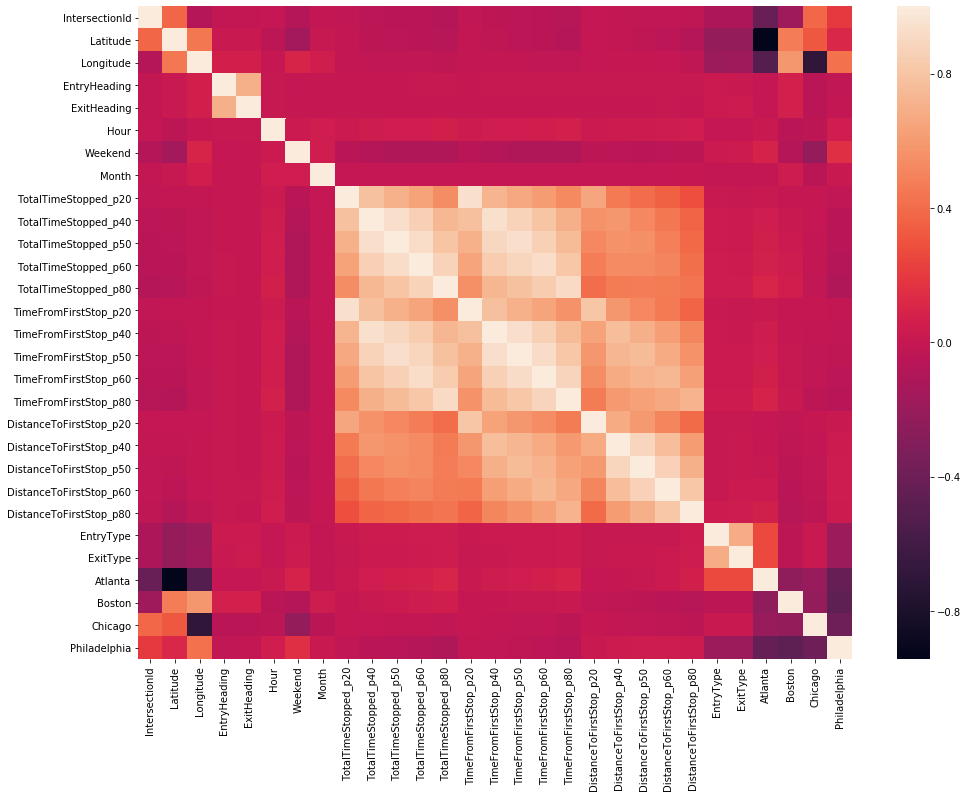

In [91]:
plt.subplots(figsize=(16,12))
sns.heatmap(train.corr(), color ='bgr4r')

In [92]:
train.corr()

,IntersectionId,Latitude,Longitude,EntryHeading,ExitHeading,Hour,Weekend,Month,TotalTimeStopped_p20,TotalTimeStopped_p40,...,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,EntryType,ExitType,Atlanta,Boston,Chicago,Philadelphia
IntersectionId,1.000000,0.377325,-0.084716,-0.015321,-0.014413,-0.005875,-0.077586,-0.014743,-0.017608,-0.041059,...,-0.014334,-0.018942,-0.020165,-0.031659,-0.109403,-0.110052,-0.424884,-0.178927,0.382175,0.199387
Latitude,0.377325,1.000000,0.450801,0.016634,0.016627,-0.037498,-0.146841,0.012643,-0.011942,-0.033164,...,-0.016293,-0.027188,-0.040579,-0.081316,-0.220806,-0.216754,-0.942148,0.475163,0.324563,0.108801
Longitude,-0.084716,0.450801,1.000000,0.060769,0.059730,0.002690,0.092612,0.056351,-0.013615,-0.017182,...,0.000221,-0.000428,-0.008807,-0.028290,-0.183505,-0.175985,-0.514348,0.588797,-0.697449,0.422935
EntryHeading,-0.015321,0.016634,0.060769,1.000000,0.699698,0.007906,-0.002175,0.002997,0.001296,0.004563,...,0.011544,0.011631,0.012509,0.012643,0.023056,0.020949,-0.004451,0.073186,-0.049874,-0.020198
ExitHeading,-0.014413,0.016627,0.059730,0.699698,1.000000,0.006681,-0.001103,0.003013,-0.000882,-0.001044,...,0.004090,0.005148,0.006819,0.005229,0.023246,0.030606,-0.006550,0.067160,-0.048912,-0.014349
Hour,-0.005875,-0.037498,0.002690,0.007906,0.006681,1.000000,0.025175,0.044394,0.027344,0.040002,...,0.032264,0.034938,0.037893,0.044623,-0.006218,-0.007701,0.016695,-0.048365,-0.034550,0.051476
Weekend,-0.077586,-0.146841,0.092612,-0.002175,-0.001103,0.025175,1.000000,0.050604,-0.049124,-0.078710,...,-0.043480,-0.048220,-0.040822,-0.038496,0.025192,0.028987,0.085480,-0.080226,-0.219356,0.157686
Month,-0.014743,0.012643,0.056351,0.002997,0.003013,0.044394,0.050604,1.000000,-0.008482,-0.009000,...,-0.005423,-0.002646,-0.002096,0.000192,-0.009091,-0.011242,-0.014227,0.038341,-0.049144,0.015286
TotalTimeStopped_p20,-0.017608,-0.011942,-0.013615,0.001296,-0.000882,0.027344,-0.049124,-0.008482,1.000000,0.782475,...,0.458303,0.401536,0.351527,0.280158,0.019418,0.012060,0.018851,0.005785,0.005078,-0.023017
TotalTimeStopped_p40,-0.041059,-0.033164,-0.017182,0.004563,-0.001044,0.040002,-0.078710,-0.009000,0.782475,1.000000,...,0.584052,0.516513,0.449664,0.370005,0.029799,0.022659,0.047081,0.020078,-0.007387,-0.047572


In [93]:
train.drop(preds.columns.tolist(), axis=1, inplace =True)

In [94]:
target1 = preds['TotalTimeStopped_p20']
target2 = preds['TotalTimeStopped_p50']
target3 = preds['TotalTimeStopped_p80']
target4 = preds['DistanceToFirstStop_p20']
target5 = preds['DistanceToFirstStop_p50']
target6 = preds['DistanceToFirstStop_p80']

In [97]:
train.columns

Index(['IntersectionId', 'Latitude', 'Longitude', 'EntryHeading',
       'ExitHeading', 'Hour', 'Weekend', 'Month', 'EntryType', 'ExitType',
       'Atlanta', 'Boston', 'Chicago', 'Philadelphia'],
      dtype='object')

In [98]:
train.head()

,IntersectionId,Latitude,Longitude,EntryHeading,ExitHeading,Hour,Weekend,Month,EntryType,ExitType,Atlanta,Boston,Chicago,Philadelphia
0,0,33.791659,-84.430032,1.75,1.75,0,0,6,2,2,1,0,0,0
1,0,33.791659,-84.430032,0.75,0.75,0,0,6,2,2,1,0,0,0
2,0,33.791659,-84.430032,1.75,1.75,1,0,6,2,2,1,0,0,0
3,0,33.791659,-84.430032,0.75,0.75,1,0,6,2,2,1,0,0,0
4,0,33.791659,-84.430032,1.75,1.75,2,0,6,2,2,1,0,0,0


In [99]:
cat_feat = ['IntersectionId','Hour', 'Weekend','Month','Atlanta', 'Boston', 'Chicago', 'Philadelphia', 'EntryType', 'ExitType']

In [100]:
all_preds = {0:[],1:[],2:[],3:[],4:[],5:[]}
all_target = [target1, target2, target3, target4, target5, target6]

In [101]:
dtrain = lgb.Dataset(data=train, label=target3)

# Objective Function
def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, lambda_l1, lambda_l2):
      
        params = {'application':'regression','num_iterations': 450,
                  'learning_rate':0.02,
                  'metric':'rmse'} # Default parameters
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        
        cv_results = lgb.cv(params, dtrain, nfold=5, seed=17,categorical_feature=cat_feat, stratified=False,
                            verbose_eval =None)
#         print(cv_results)
        return -np.min(cv_results['rmse-mean'])

In [102]:
pds = {'num_leaves': (120, 230),
          'feature_fraction': (0.3, 0.9),
          'bagging_fraction': (0.8, 1),
           'lambda_l1': (0,3),
           'lambda_l2': (0,5),
          'max_depth': (8, 19),
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (1, 20)
          }

In [103]:
# Surrogate model
optimizer = BayesianOptimization(hyp_lgbm,pds,random_state=7)
                                  
# Optimize
optimizer.maximize(init_points=5, n_iter=12)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Atlanta', 'Boston', 'Chicago', 'EntryType', 'ExitType', 'Hour', 'IntersectionId', 'Month', 'Philadelphia', 'Weekend']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


|  1        | -19.13    |  0.8153   |  0.768    |  1.315    |  3.617    |  18.76    |  11.23    |  0.05061  |  127.9    |
|  2        | -20.53    |  0.8537   |  0.5999   |  2.038    |  4.019    |  12.19    |  2.253    |  0.02953  |  220.1    |
|  3        | -20.19    |  0.8427   |  0.5713   |  2.794    |  0.1245   |  14.61    |  19.05    |  0.0238   |  180.3    |
|  4        | -21.44    |  0.9818   |  0.3799   |  1.57     |  3.752    |  15.36    |  9.887    |  0.02128  |  174.0    |
|  5        | -20.3     |  0.8745   |  0.5864   |  1.098    |  4.19     |  16.46    |  6.966    |  0.05769  |  150.4    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  6        | -21.87    |  0.9688   |  0.4801   |  2.393    |  3.191    |  9.065    |  6.043    |  0.02435  |  139.3    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  7        | -19.23    |  0.9611   |  0.7898   |  1.723    |  1.706    |  17.24    |  18.72    |  0.05284  |  131.7    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  8        | -20.21    |  0.9233   |  0.5599   |  0.9111   |  2.981    |  18.18    |  10.74    |  0.03754  |  128.0    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  9        | -21.48    |  0.8853   |  0.3721   |  2.19     |  3.232    |  18.96    |  12.02    |  0.02852  |  127.9    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  10       | -19.5     |  0.8366   |  0.7286   |  1.55     |  3.791    |  18.93    |  11.74    |  0.01321  |  128.8    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  11       | -18.94    |  0.8729   |  0.8475   |  1.683    |  0.8204   |  16.92    |  17.76    |  0.001319 |  132.0    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  12       | -21.07    |  0.8731   |  0.4191   |  2.364    |  0.9699   |  17.34    |  18.19    |  0.09898  |  131.7    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  13       | -19.73    |  0.8984   |  0.7042   |  1.214    |  4.042    |  16.12    |  7.152    |  0.09157  |  150.4    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  14       | -20.19    |  0.9606   |  0.5916   |  0.9667   |  0.4953   |  17.93    |  18.36    |  0.05522  |  131.4    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  15       | -19.46    |  0.8853   |  0.711    |  0.7457   |  3.504    |  18.99    |  12.45    |  0.08843  |  129.3    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  16       | -19.53    |  0.9855   |  0.6995   |  1.422    |  2.415    |  15.5     |  10.65    |  0.02697  |  169.7    |


/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  17       | -21.45    |  0.9533   |  0.3813   |  1.387    |  2.205    |  14.9     |  10.68    |  0.006277 |  168.7    |


In [104]:
optimizer.max

{'target': -18.94194776868642,
 'params': {'bagging_fraction': 0.8728979441521825,
  'feature_fraction': 0.8475301008583984,
  'lambda_l1': 1.6827840936024212,
  'lambda_l2': 0.8203646667959497,
  'max_depth': 16.91893902201613,
  'min_child_weight': 17.755468495843722,
  'min_split_gain': 0.0013188746714816412,
  'num_leaves': 131.99392002113098}}

In [105]:
p = optimizer.max['params']

In [106]:
param = {'num_leaves': int(round(p['num_leaves'])),
         'feature_fraction': p['feature_fraction'],
         'bagging_fraction': p['bagging_fraction'],
         'max_depth': int(round(p['max_depth'])),
         'lambda_l1': p['lambda_l1'],
         'lambda_l2': p['lambda_l2'],
         'min_split_gain': p['min_split_gain'],
         'min_child_weight': p['min_child_weight'],
         'learning_rate':0.05,
         'objective': 'regression',
         'boosting_type': 'gbdt',
         'verbose': 1,
         'metric': 'rmse',
         'seed': 7,
        }

In [107]:
param

{'num_leaves': 132,
 'feature_fraction': 0.8475301008583984,
 'bagging_fraction': 0.8728979441521825,
 'max_depth': 17,
 'lambda_l1': 1.6827840936024212,
 'lambda_l2': 0.8203646667959497,
 'min_split_gain': 0.0013188746714816412,
 'min_child_weight': 17.755468495843722,
 'learning_rate': 0.05,
 'objective': 'regression',
 'boosting_type': 'gbdt',
 'verbose': 1,
 'metric': 'rmse',
 'seed': 7}

In [111]:
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error

In [113]:
%%time
nfold = 5
kf = KFold(n_splits=nfold, random_state=227, shuffle=True)
for i in range(len(all_preds)):
    print('Training and predicting for target {}'.format(i+1))
    oof = np.zeros(len(train))
    all_preds[i] = np.zeros(len(test))
    n =1
    for train_index, valid_index in kf.split(all_target[i]):
        print("fold {}".format(n))
        xg_train = lgb.Dataset(train.iloc[train_index],
                               label=all_target[i][train_index]
                               )
        xg_valid = lgb.Dataset(train.iloc[valid_index],
                               label=all_target[i][valid_index]
                               )   

        clf = lgb.train(param, xg_train, 15000, valid_sets=[xg_valid],categorical_feature=cat_feat
                        , verbose_eval=200, early_stopping_rounds=100)
        oof[valid_index] = clf.predict(train.iloc[valid_index], num_iteration=clf.best_iteration) 

        all_preds[i] += clf.predict(test, num_iteration=clf.best_iteration) / nfold
        n = n + 1

    print("\n\nCV RMSE: {:<0.4f}".format(np.sqrt(mean_squared_error(all_target[i], oof))))  

Training and predicting for target 1
fold 1
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 5.77119
[400]	valid_0's rmse: 5.64785
[600]	valid_0's rmse: 5.60631
[800]	valid_0's rmse: 5.58675
[1000]	valid_0's rmse: 5.57683
[1200]	valid_0's rmse: 5.56957
[1400]	valid_0's rmse: 5.56068
[1600]	valid_0's rmse: 5.55346
[1800]	valid_0's rmse: 5.55098
[2000]	valid_0's rmse: 5.54706
[2200]	valid_0's rmse: 5.54545
[2400]	valid_0's rmse: 5.54328
[2600]	valid_0's rmse: 5.54217
[2800]	valid_0's rmse: 5.53979
Early stopping, best iteration is:
[2778]	valid_0's rmse: 5.53946
fold 2
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 5.8828
[400]	valid_0's rmse: 5.74749
[600]	valid_0's rmse: 5.69914
[800]	valid_0's rmse: 5.6813
[1000]	valid_0's rmse: 5.66885
[1200]	valid_0's rmse: 5.65561
[1400]	valid_0's rmse: 5.65112
[1600]	valid_0's rmse: 5.64569
[1800]	valid_0's rmse: 5.63986
[2000]	valid_0's rmse: 5.6334
[2200]	valid_0's rmse: 5.6

/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Atlanta', 'Boston', 'Chicago', 'EntryType', 'ExitType', 'Hour', 'IntersectionId', 'Month', 'Philadelphia', 'Weekend']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 10.7179
[400]	valid_0's rmse: 10.241
[600]	valid_0's rmse: 10.0706
[800]	valid_0's rmse: 10.0123
[1000]	valid_0's rmse: 9.94475
[1200]	valid_0's rmse: 9.90177
[1400]	valid_0's rmse: 9.87568
[1600]	valid_0's rmse: 9.84737
[1800]	valid_0's rmse: 9.81367
[2000]	valid_0's rmse: 9.79045
[2200]	valid_0's rmse: 9.76854
[2400]	valid_0's rmse: 9.75114
[2600]	valid_0's rmse: 9.73839
[2800]	valid_0's rmse: 9.72363
[3000]	valid_0's rmse: 9.7123
[3200]	valid_0's rmse: 9.70711
[3400]	valid_0's rmse: 9.69925
[3600]	valid_0's rmse: 9.69021
[3800]	valid_0's rmse: 9.68312
[4000]	valid_0's rmse: 9.67573
[4200]	valid_0's rmse: 9.67003
[4400]	valid_0's rmse: 9.66384
[4600]	valid_0's rmse: 9.65902
[4800]	valid_0's rmse: 9.65206
[5000]	valid_0's rmse: 9.64788
[5200]	valid_0's rmse: 9.64546
[5400]	valid_0's rmse: 9.64284
[5600]	valid_0's rmse: 9.63878
[5800]	valid_0's rmse: 9.6357
[6000]	valid_0's rmse: 9.63173
[6200]	valid_0'

/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Atlanta', 'Boston', 'Chicago', 'EntryType', 'ExitType', 'Hour', 'IntersectionId', 'Month', 'Philadelphia', 'Weekend']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 18.5729
[400]	valid_0's rmse: 17.5385
[600]	valid_0's rmse: 17.1952
[800]	valid_0's rmse: 17.027
[1000]	valid_0's rmse: 16.9032
[1200]	valid_0's rmse: 16.7956
[1400]	valid_0's rmse: 16.7357
[1600]	valid_0's rmse: 16.6889
[1800]	valid_0's rmse: 16.6351
[2000]	valid_0's rmse: 16.5819
[2200]	valid_0's rmse: 16.5446
[2400]	valid_0's rmse: 16.5124
[2600]	valid_0's rmse: 16.4848
[2800]	valid_0's rmse: 16.444
[3000]	valid_0's rmse: 16.4207
[3200]	valid_0's rmse: 16.3953
[3400]	valid_0's rmse: 16.3719
[3600]	valid_0's rmse: 16.3565
[3800]	valid_0's rmse: 16.3414
[4000]	valid_0's rmse: 16.3259
[4200]	valid_0's rmse: 16.3147
[4400]	valid_0's rmse: 16.3013
[4600]	valid_0's rmse: 16.2892
[4800]	valid_0's rmse: 16.2775
[5000]	valid_0's rmse: 16.2658
[5200]	valid_0's rmse: 16.2569
[5400]	valid_0's rmse: 16.2462
[5600]	valid_0's rmse: 16.2373
[5800]	valid_0's rmse: 16.226
[6000]	valid_0's rmse: 16.2177
[6200]	valid_0'

/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Atlanta', 'Boston', 'Chicago', 'EntryType', 'ExitType', 'Hour', 'IntersectionId', 'Month', 'Philadelphia', 'Weekend']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 25.3258
[400]	valid_0's rmse: 24.9864
[600]	valid_0's rmse: 24.8774
[800]	valid_0's rmse: 24.8341
[1000]	valid_0's rmse: 24.8019
[1200]	valid_0's rmse: 24.7942
Early stopping, best iteration is:
[1124]	valid_0's rmse: 24.783
fold 2
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 24.9183
[400]	valid_0's rmse: 24.6363
[600]	valid_0's rmse: 24.5852
[800]	valid_0's rmse: 24.5649
Early stopping, best iteration is:
[834]	valid_0's rmse: 24.5571
fold 3
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 25.5316
[400]	valid_0's rmse: 25.2007
[600]	valid_0's rmse: 25.1401
[800]	valid_0's rmse: 25.1223
[1000]	valid_0's rmse: 25.0913
[1200]	valid_0's rmse: 25.0905
Early stopping, best iteration is:
[1128]	valid_0's rmse: 25.0693
fold 4
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 24.536
[400]	valid_0's rmse: 

/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Atlanta', 'Boston', 'Chicago', 'EntryType', 'ExitType', 'Hour', 'IntersectionId', 'Month', 'Philadelphia', 'Weekend']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 53.4387
[400]	valid_0's rmse: 51.9597
[600]	valid_0's rmse: 51.5955
[800]	valid_0's rmse: 51.4367
[1000]	valid_0's rmse: 51.3588
[1200]	valid_0's rmse: 51.3166
[1400]	valid_0's rmse: 51.2651
[1600]	valid_0's rmse: 51.1872
[1800]	valid_0's rmse: 51.1614
Early stopping, best iteration is:
[1718]	valid_0's rmse: 51.154
fold 2
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 52.1317
[400]	valid_0's rmse: 50.897
[600]	valid_0's rmse: 50.6724
[800]	valid_0's rmse: 50.5227
[1000]	valid_0's rmse: 50.4677
[1200]	valid_0's rmse: 50.396
[1400]	valid_0's rmse: 50.3524
Early stopping, best iteration is:
[1367]	valid_0's rmse: 50.3402
fold 3
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 52.3389
[400]	valid_0's rmse: 50.9302
[600]	valid_0's rmse: 50.6282
[800]	valid_0's rmse: 50.4905
[1000]	valid_0's rmse: 50.4026
[1200]	valid_0's rmse: 50.3405
[

/Users/mannankant/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Atlanta', 'Boston', 'Chicago', 'EntryType', 'ExitType', 'Hour', 'IntersectionId', 'Month', 'Philadelphia', 'Weekend']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 89.978
[400]	valid_0's rmse: 86.3669
[600]	valid_0's rmse: 85.4257
[800]	valid_0's rmse: 84.9394
[1000]	valid_0's rmse: 84.6358
[1200]	valid_0's rmse: 84.3844
[1400]	valid_0's rmse: 84.2414
[1600]	valid_0's rmse: 84.1351
[1800]	valid_0's rmse: 84.041
[2000]	valid_0's rmse: 83.9698
[2200]	valid_0's rmse: 83.947
[2400]	valid_0's rmse: 83.9213
Early stopping, best iteration is:
[2349]	valid_0's rmse: 83.9156
fold 2
Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 90.9071
[400]	valid_0's rmse: 87.2767
[600]	valid_0's rmse: 86.511
[800]	valid_0's rmse: 86.1275
[1000]	valid_0's rmse: 85.6994
[1200]	valid_0's rmse: 85.48
[1400]	valid_0's rmse: 85.2875
[1600]	valid_0's rmse: 85.1892
[1800]	valid_0's rmse: 85.0904
[2000]	valid_0's rmse: 85.0294
Early stopping, best iteration is:
[2020]	valid_0's rmse: 85.0201
fold 3
Training until validation scores don't improve for 100 rounds


In [124]:
data2 = pd.DataFrame(all_preds).stack()
data2 = pd.DataFrame(data2)
submission['Target'] = data2[0].values

ValueError: Length of values does not match length of index

In [123]:
submission = pd.read_csv('bigquery-geotab-intersection-congestion/sample_submission.csv')

In [117]:
submission.count()

TargetId    11522010
Target      11522010
dtype: int64

In [118]:
data2[0].count()

11528142

In [125]:
submission.count()

TargetId    11522010
Target      11522010
dtype: int64

In [121]:
data2.head()

0
0 0  -0.834396
  1   2.601955
  2  20.997693
  3   1.009911
  4  11.962251